In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

In [2]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}
VOLUME_SLICES = 145 #[100]
VOLUME_START_AT = 5 # first slice of volume that we will include [22]

In [ ]:
import nilearn as nl
import nibabel as nib
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

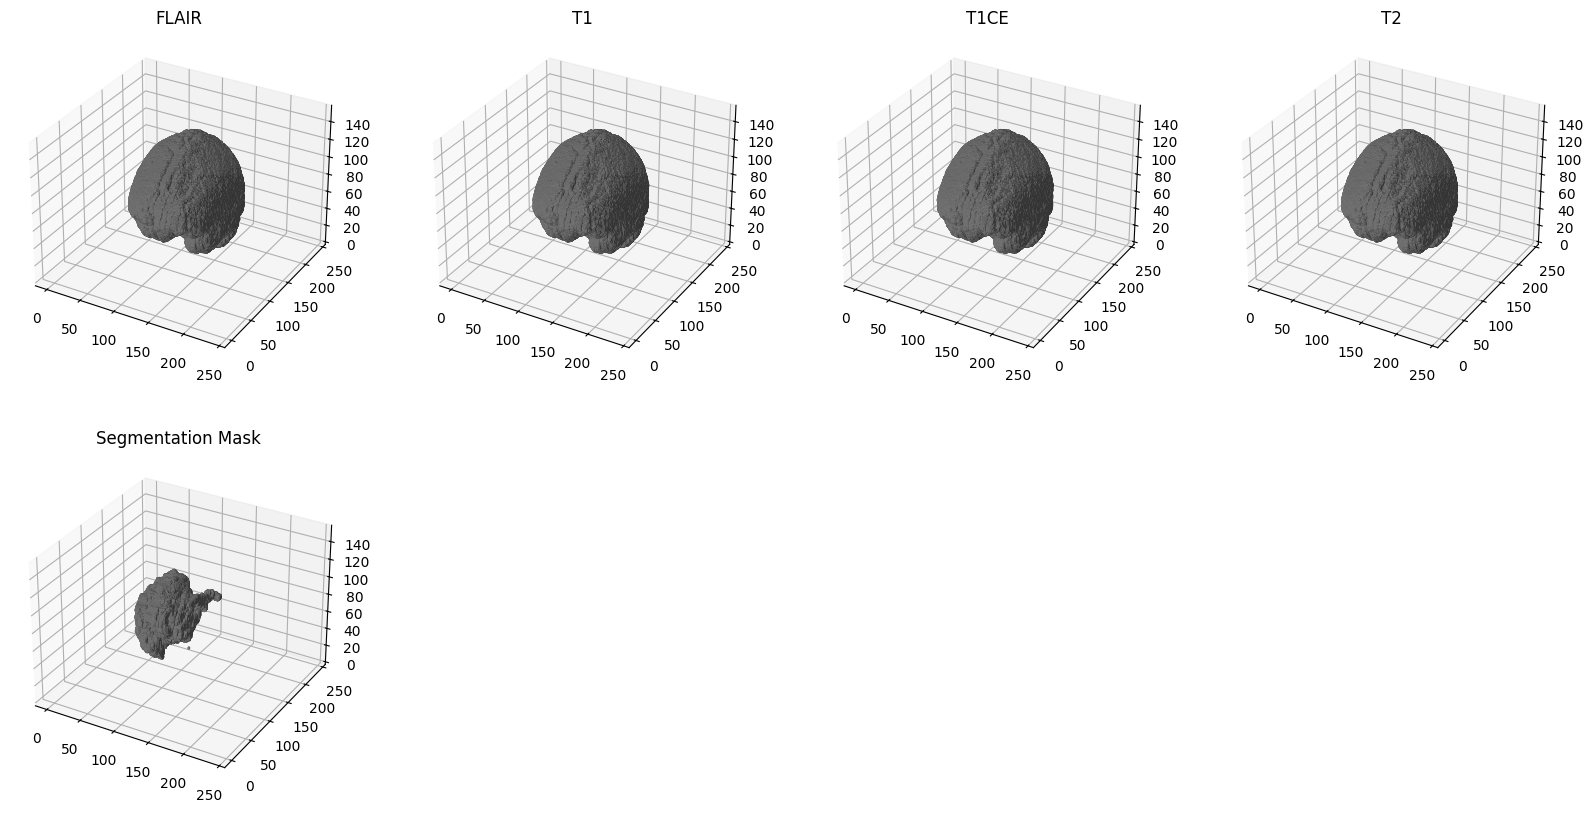

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))

# Plot the FLAIR image
ax_flair = fig.add_subplot(241, projection='3d')
ax_flair.set_title('FLAIR')
ax_flair.voxels(test_image_flair, edgecolors='gray')

# Plot the T1 image
ax_flair = fig.add_subplot(242, projection='3d')
ax_flair.set_title('T1')
ax_flair.voxels(test_image_flair, edgecolors='gray')

# Plot the T1CE image
ax_t1ce = fig.add_subplot(243, projection='3d')
ax_t1ce.set_title('T1CE')
ax_t1ce.voxels(test_image_t1ce, edgecolors='gray')

# Plot the T2 image
ax_t2 = fig.add_subplot(244, projection='3d')
ax_t2.set_title('T2')
ax_t2.voxels(test_image_t2, edgecolors='gray')

# Plot the Segmentation mask
ax_mask = fig.add_subplot(245, projection='3d')
ax_mask.set_title('Segmentation Mask')
ax_mask.voxels(test_mask, edgecolors='gray', facecolors='r', alpha=0.4)

plt.show()

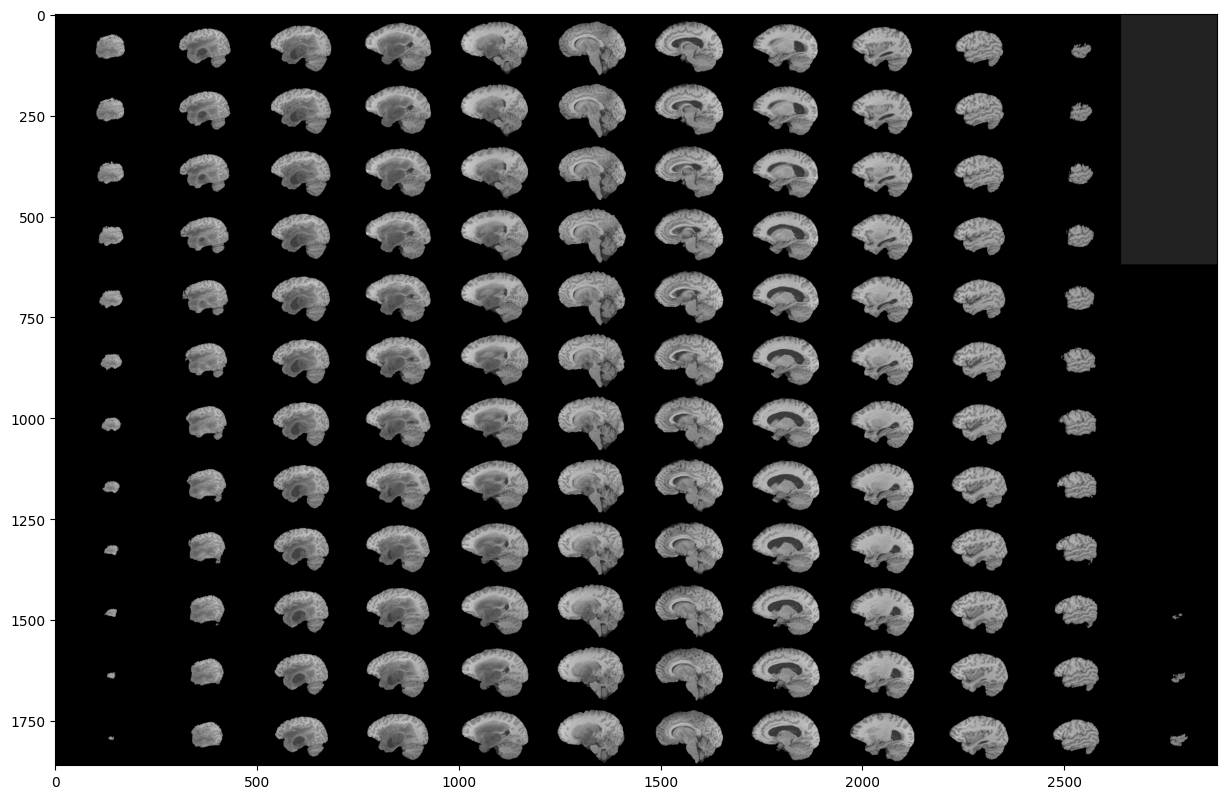

In [5]:
from skimage.transform import rotate
from skimage.transform import resize
from skimage.util import montage 
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

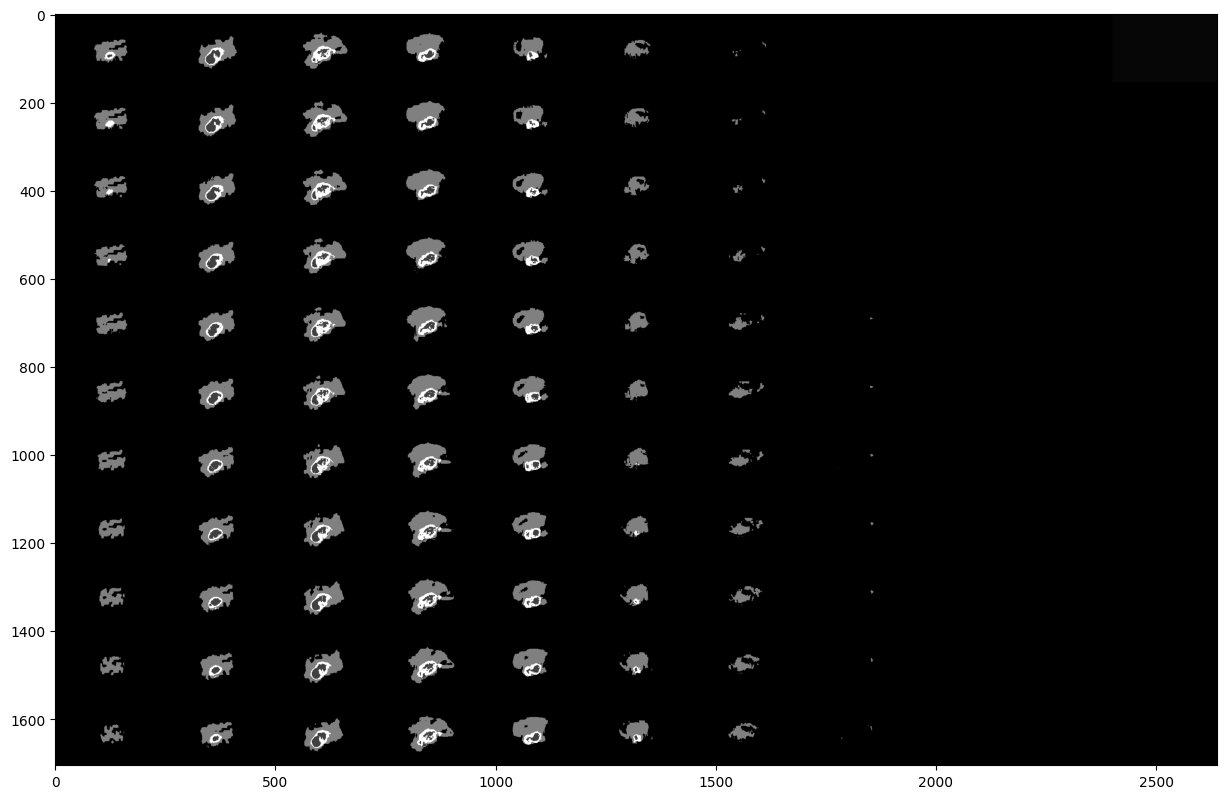

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

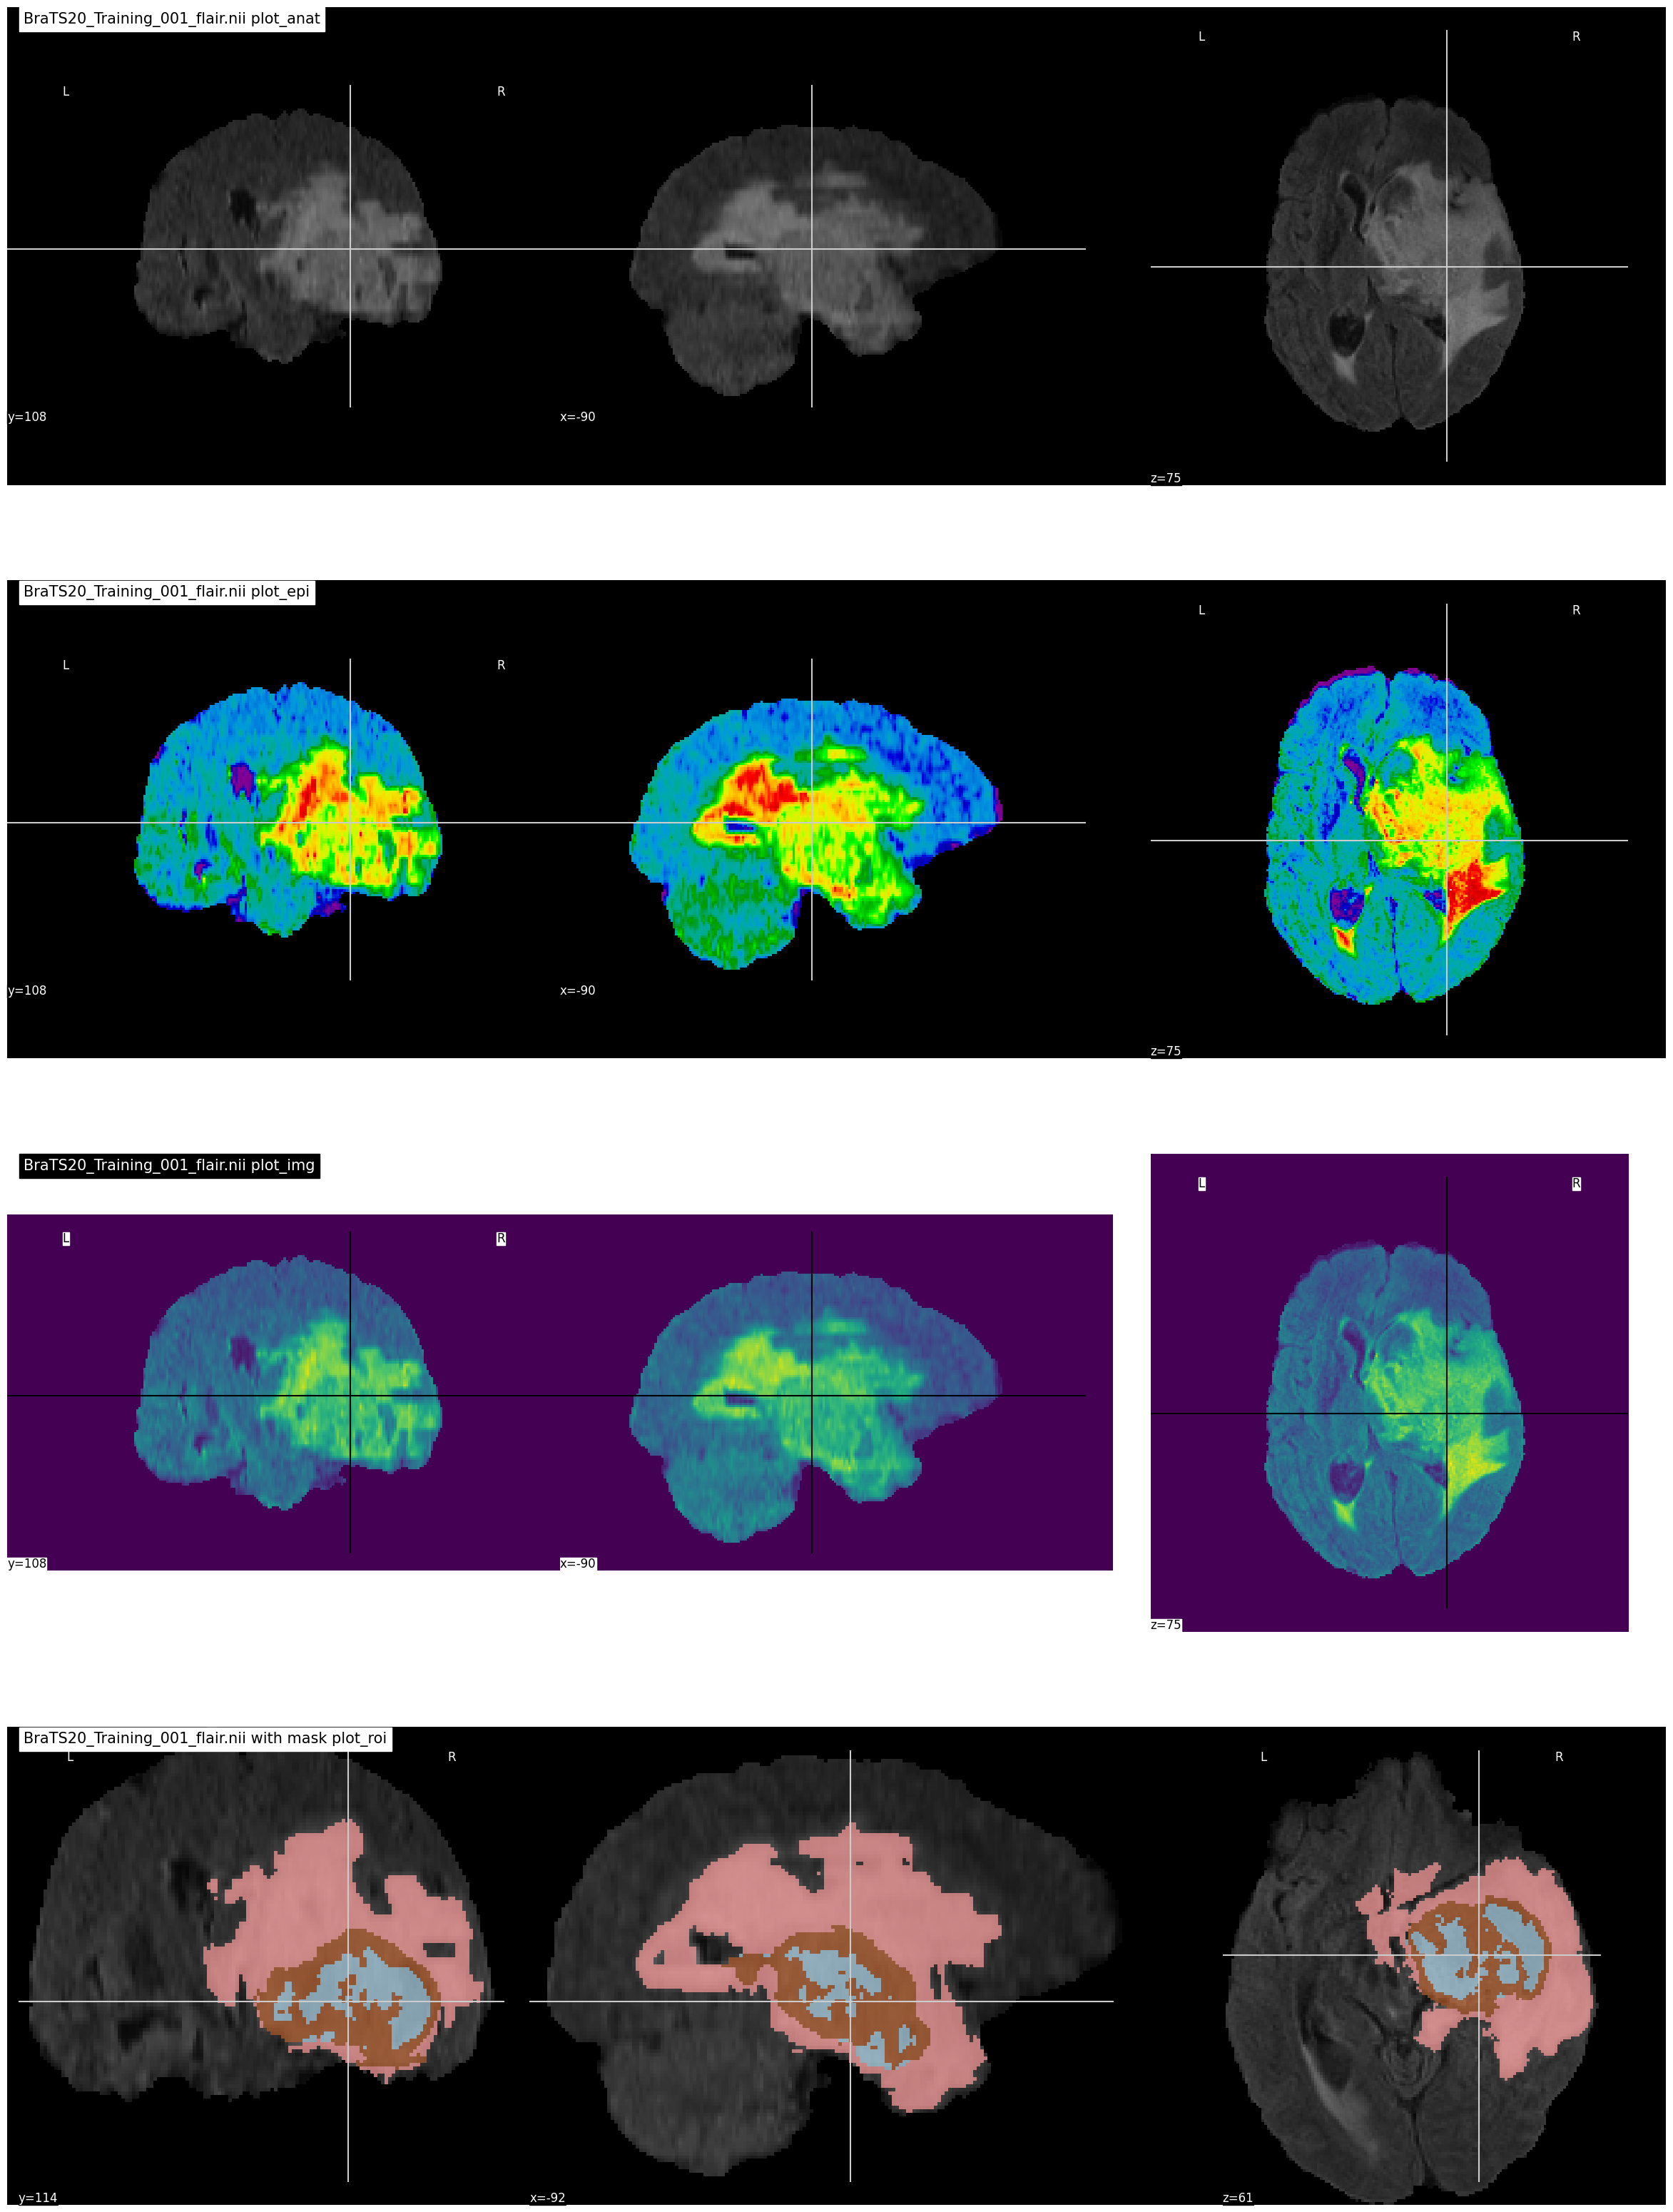

In [7]:
import nilearn.plotting as nlplt
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()


In [8]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def dice_coef_not_tumor(y_true, y_pred, epsilon=1e-6):
   intersection = K.sum(K.abs(y_true[:,:,:,0] * y_pred[:,:,:,0]))
   return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,0])) + K.sum(K.square(y_pred[:,:,:,0])) + epsilon)

def hausdorff_distance(mask1, mask2):
    # Find the coordinates of non-zero elements in the binary masks
    points_mask1 = np.array(np.where(mask1)).T
    points_mask2 = np.array(np.where(mask2)).T

    # Calculate the directed Hausdorff distance in both directions
    distance_1_to_2 = directed_hausdorff(points_mask1, points_mask2)[0]
    distance_2_to_1 = directed_hausdorff(points_mask2, points_mask1)[0]

    # Return the maximum of the two distances
    hausdorff_dist = max(distance_1_to_2, distance_2_to_1)
    return hausdorff_dist

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
IMG_SIZE =128

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D,  Input,  concatenate, Dropout
from tensorflow.keras.optimizers import *


def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), 
                         dice_coefficient, precision, sensitivity, 
                         specificity, dice_coef_necrotic, dice_coef_edema ,
                         dice_coef_enhancing, dice_coef_not_tumor] )

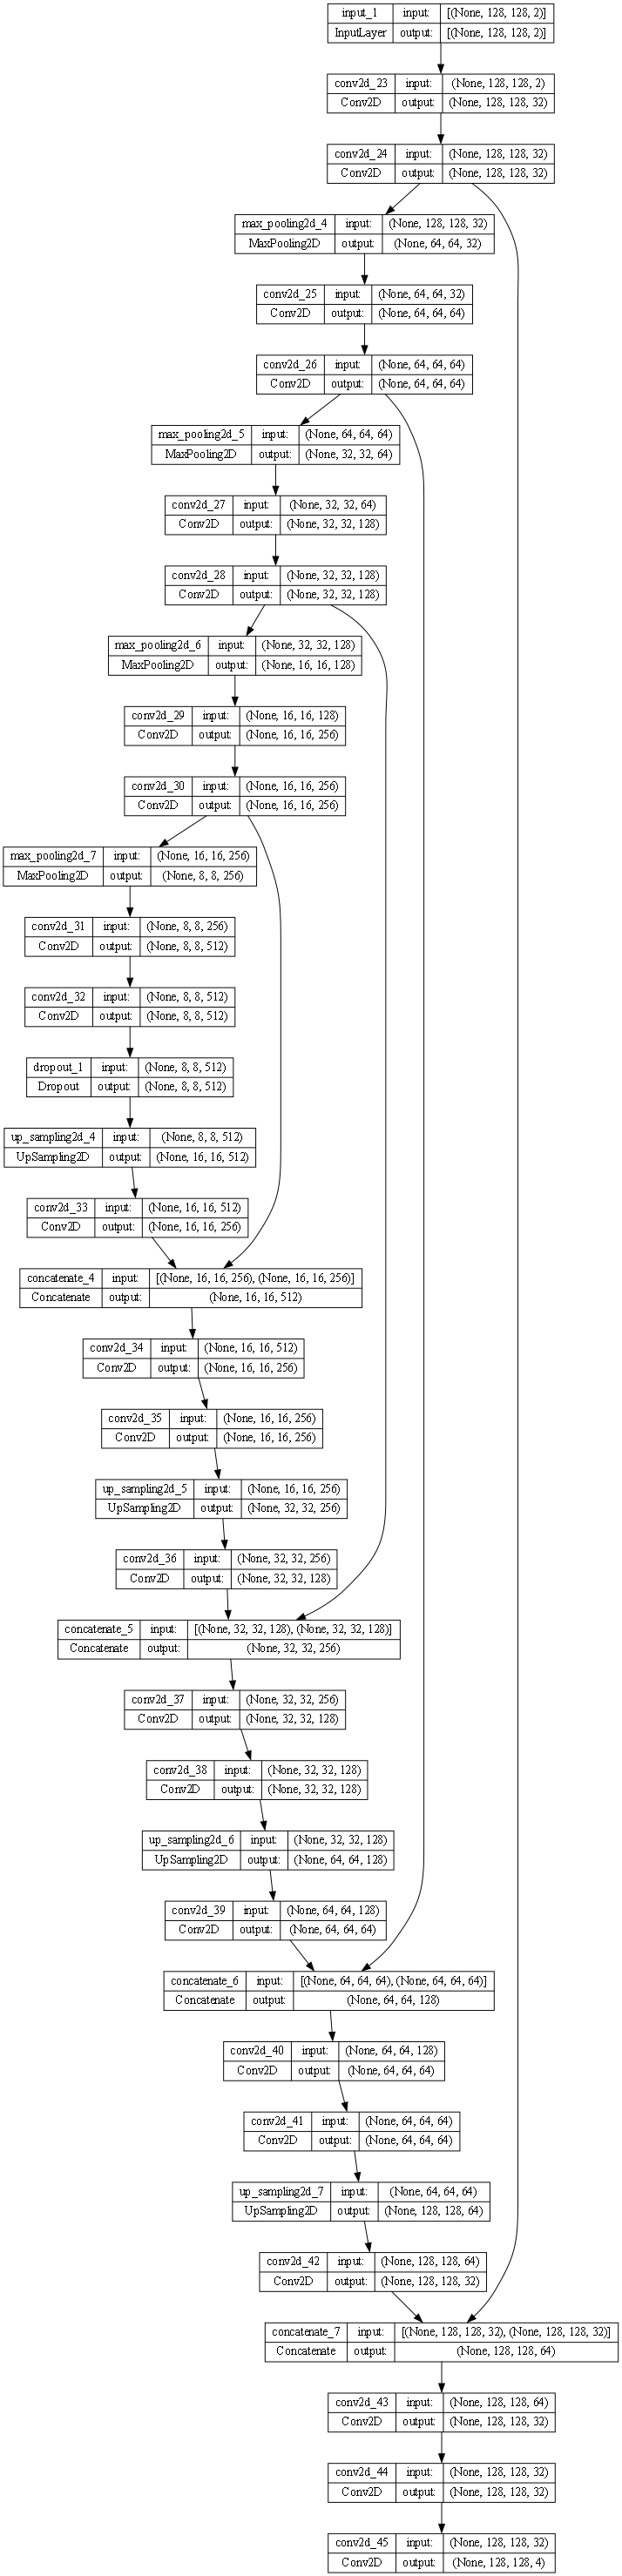

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [12]:
import os
from sklearn.model_selection import train_test_split

train_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
val_and_test_directories = [f.path for f in os.scandir(VALIDATION_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

training_ids = pathListIntoIds(train_directories)

train_test_ids, val_ids = train_test_split(training_ids,test_size=0.15) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.2) 

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')


    plt.savefig('data_distribution.jpg')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


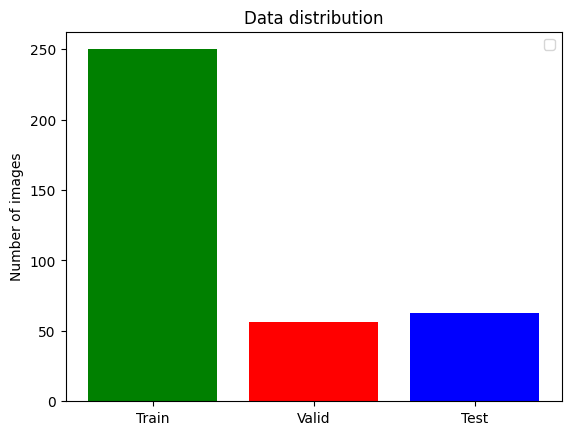

In [13]:
showDataLayout()

In [14]:
import cv2
def resize3d(input_size, target_size, axis):
    # Reshape the 3D image into a stack of 2D slices
    image_slices = tf.unstack(input_size, axis=axis)

# Resize each 2D slice individually
    resized_slices = []
    for slice in image_slices:
        slice = np.array(slice)
        resized_slice = cv2.resize(slice, (target_size[0], target_size[1]), interpolation=cv2.INTER_LINEAR)
        resized_slices.append(resized_slice)

# Stack the resized slices back into a 3D image
    resized_image_3d = tf.stack(resized_slices, axis=axis)
    return resized_image_3d

In [15]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
target_size = (IMG_SIZE, IMG_SIZE, IMG_SIZE)
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Generate masks
        y[y==4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X/np.max(X), Y

In [16]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [17]:
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import  ReduceLROnPlateau
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [18]:
epoch = 1

In [20]:
K.clear_session()

history =  model.fit(training_generator,
                     epochs= epoch, # change epoch into 35
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model.save("model_x1_2.h5")

250/250 [==============================] - 8744s 35s/step - loss: 0.0542 - accuracy: 0.9883 - mean_io_u: 0.6491 - dice_coefficient: 0.2730 - precision: 0.9885 - sensitivity: 0.9876 - specificity: 0.9962 - dice_coef_necrotic: 0.0640 - dice_coef_edema: 0.1278 - dice_coef_enhancing: 0.0553 - dice_coef_not_tumor: 0.9946 - val_loss: 0.0478 - val_accuracy: 0.9878 - val_mean_io_u: 0.5820 - val_dice_coefficient: 0.2839 - val_precision: 0.9877 - val_sensitivity: 0.9877 - val_specificity: 0.9959 - val_dice_coef_necrotic: 0.0986 - val_dice_coef_edema: 0.1812 - val_dice_coef_enhancing: 0.0694 - val_dice_coef_not_tumor: 0.9952 - lr: 0.0010


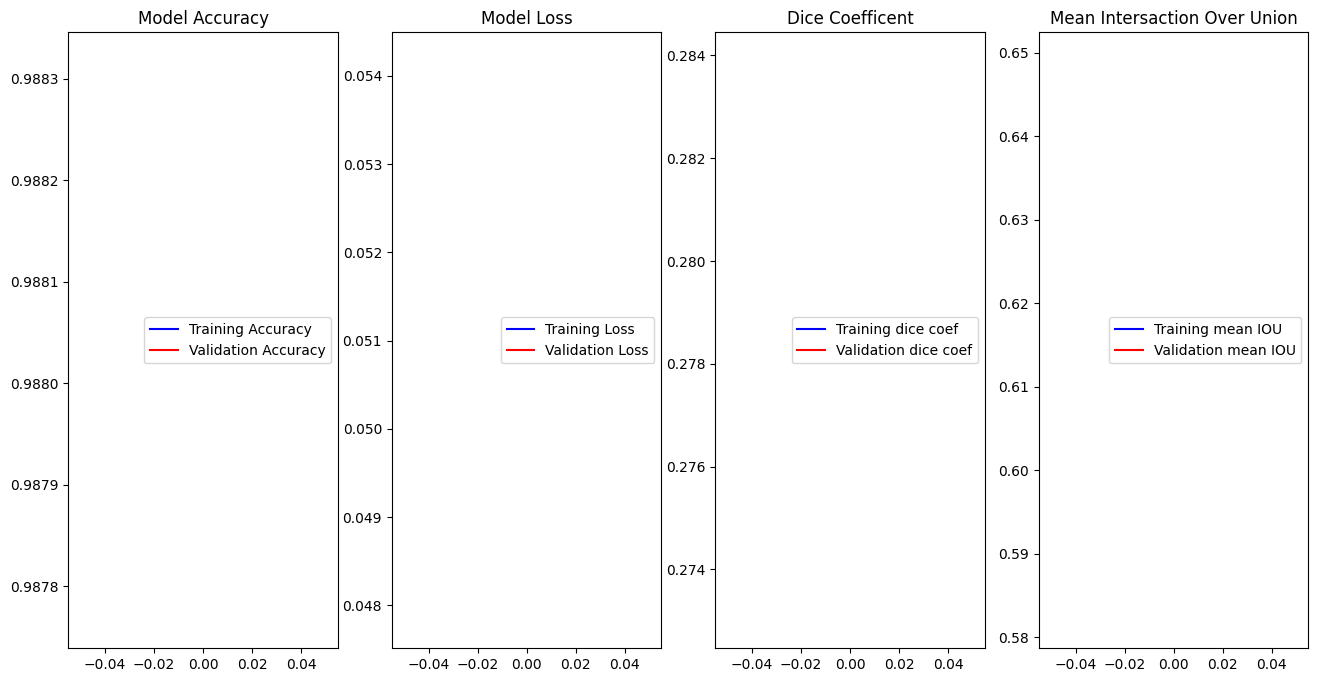

In [21]:
import pandas as pd
from tensorflow import keras
model = keras.models.load_model('model_x1_1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coefficient": dice_coefficient,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training.log', sep=',', engine='python')

hist=history
############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coefficient']
val_dice=hist['val_dice_coefficient']

f,ax=plt.subplots(1,4,figsize=(16,8))
ax[0].set_title('Model Accuracy')
ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].set_title('Model Loss')
ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()


ax[2].set_title('Dice Coefficent')
ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


ax[3].set_title('Mean Intersaction Over Union')
ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()
plt.show()

In [23]:
def predictByPath3D(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((IMG_SIZE, IMG_SIZE, IMG_SIZE, 2))

    vol_path_flair = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path_flair).get_fdata()

    vol_path_ce = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path_ce).get_fdata()

    flair = resize3d(flair, target_size, axis=2)
    flair = resize3d(flair, target_size, axis=0)
    #flair = flair[np.newaxis, ...]  # Add extra dimension

    ce = resize3d(ce, target_size, axis=2)
    ce = resize3d(ce, target_size, axis=0)
    #ce = ce[np.newaxis, ...]  # Add extra dimension

    X[:,:,:,0]= flair
    X[:,:,:,1] = ce

    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

def showPredictsById3D(case):
    path = f"BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath3D(path, case)

    core = p[:, :, :, 1:1]
    edema = p[:, :, :, 1:2]
    enhancing = p[:, :, :, 1:3]

    fig = plt.figure(figsize=(18, 18))
    ax1 = fig.add_subplot(231, projection='3d')
    ax2 = fig.add_subplot(232, projection='3d')
    ax3 = fig.add_subplot(233, projection='3d')
    ax4 = fig.add_subplot(234, projection='3d')
    ax5 = fig.add_subplot(235, projection='3d')

    # Voxel plot for Ground Truth
    ax1.voxels(gt, facecolors='red', edgecolor='gray', alpha=0.5)
    ax1.set_title('Ground Truth')

    # Voxel plot for Predicted - All Classes
    ax2.voxels(origImage, facecolors='red', edgecolor='gray', alpha=0.5)
    ax2.set_title('Origin Image')

    # Voxel plot for Predicted - Enhancing
    ax3.voxels(edema, facecolors='red', edgecolor='blue', alpha=0.5)
    ax3.set_title(f'Predicted - {SEGMENT_CLASSES[1]}')
    
    ax4.voxels(core, facecolors='red', edgecolor='red', alpha=0.5)
    ax4.set_title(f'Predicted - {SEGMENT_CLASSES[2]}')

    ax5.voxels(enhancing, facecolors='red', edgecolor='orange', alpha=0.5)
    ax5.set_title(f'Predicted - {SEGMENT_CLASSES[3]}')
    plt.show()


In [ ]:
print(predictByPath3D(TRAIN_DATASET_PATH+'/BraTS20_Training_001', '001'))

4/4 [==============================] - 8s 2s/step
[[[[0.531 0.06  0.303 0.107]
   [0.679 0.023 0.199 0.1  ]
   [0.832 0.007 0.111 0.049]
   ...
   [0.813 0.022 0.093 0.071]
   [0.718 0.064 0.126 0.091]
   [0.601 0.097 0.2   0.102]]

  [[0.801 0.029 0.109 0.061]
   [0.871 0.004 0.094 0.031]
   [0.951 0.002 0.036 0.011]
   ...
   [0.928 0.019 0.036 0.017]
   [0.885 0.041 0.05  0.025]
   [0.727 0.082 0.138 0.054]]

  [[0.84  0.025 0.096 0.038]
   [0.922 0.003 0.056 0.019]
   [0.972 0.001 0.022 0.005]
   ...
   [0.97  0.006 0.021 0.004]
   [0.952 0.013 0.028 0.006]
   [0.825 0.039 0.113 0.023]]

  ...

  [[0.773 0.08  0.081 0.067]
   [0.95  0.014 0.022 0.014]
   [0.975 0.007 0.014 0.004]
   ...
   [0.953 0.015 0.029 0.003]
   [0.895 0.025 0.071 0.009]
   [0.643 0.071 0.235 0.05 ]]

  [[0.733 0.129 0.064 0.074]
   [0.946 0.02  0.018 0.016]
   [0.961 0.022 0.009 0.007]
   ...
   [0.92  0.04  0.027 0.013]
   [0.839 0.055 0.077 0.03 ]
   [0.546 0.143 0.217 0.093]]

  [[0.505 0.246 0.121 0.129]

4/4 - 8s - 8s/epoch - 2s/step


KeyboardInterrupt: 

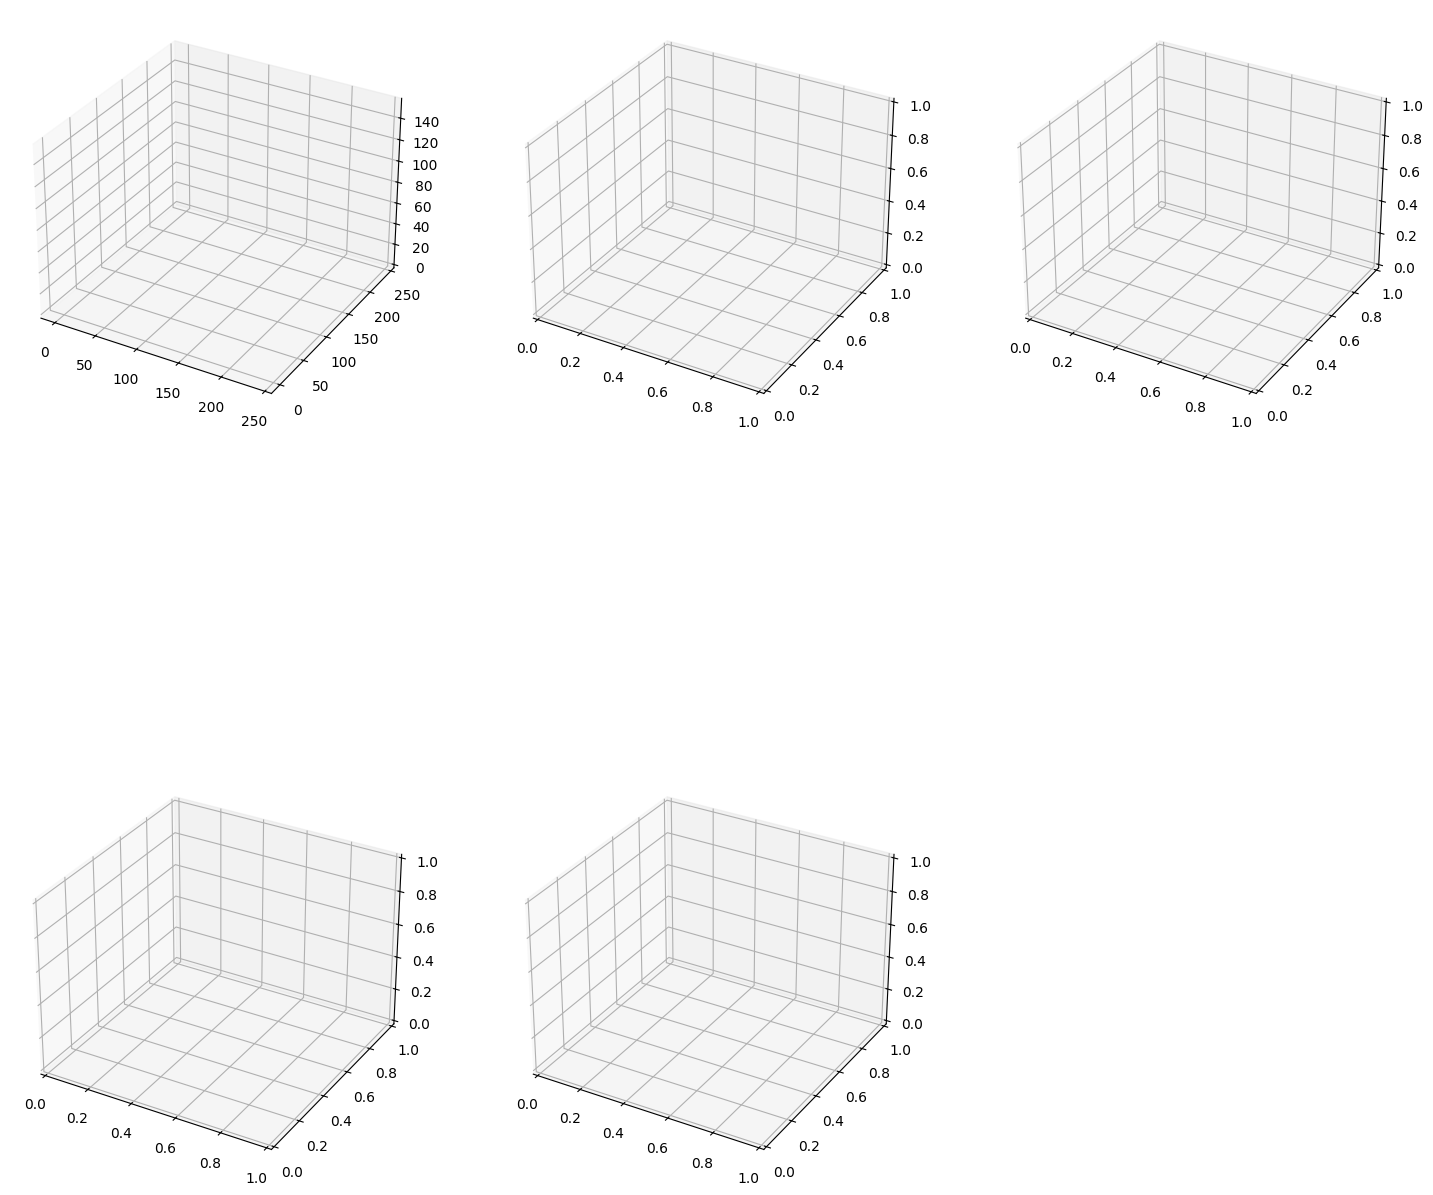

In [25]:
for i in range(5):
    showPredictsById3D(case=test_ids[i][-3:][-3:])